# Reinforcement Learning

Code demo: Battery management agent to optimize discharge current for maximum cycle (minimum capacity degragation)
## Part 1. Generate synthesis battery data and create a simulator

### Generate synthesis battery data


STEP 1: GENERATE SYNTHETIC BATTERY DISCHARGE DATA (RL-READY TRAJECTORIES)

Generating 50 battery trajectories (with EOL tracking)...
  EOL threshold: 0.8 Ahr
  Initial capacity: 5.0 Ahr
  Measurement noise: ±2.0%
  Simulated 10 batteries
  Simulated 20 batteries
  Simulated 30 batteries
  Simulated 40 batteries
  Simulated 50 batteries

✓ Synthetic trajectory data generated:
  Total batteries: 50
  Total cycles recorded: 3193
  Avg cycles per battery: 63.9
  Capacity range: 0.2772 to 5.0000 Ahr
  Capacity mean: 3.3344 Ahr, std: 1.1489 Ahr

Battery Lifetime Statistics:
  Mean cycles to EOL: 63.9
  Min cycles to EOL: 53
  Max cycles to EOL: 77
  Std dev: 5.5

✓ Synthetic data visualizations saved to synthetic_battery_trajectories.png


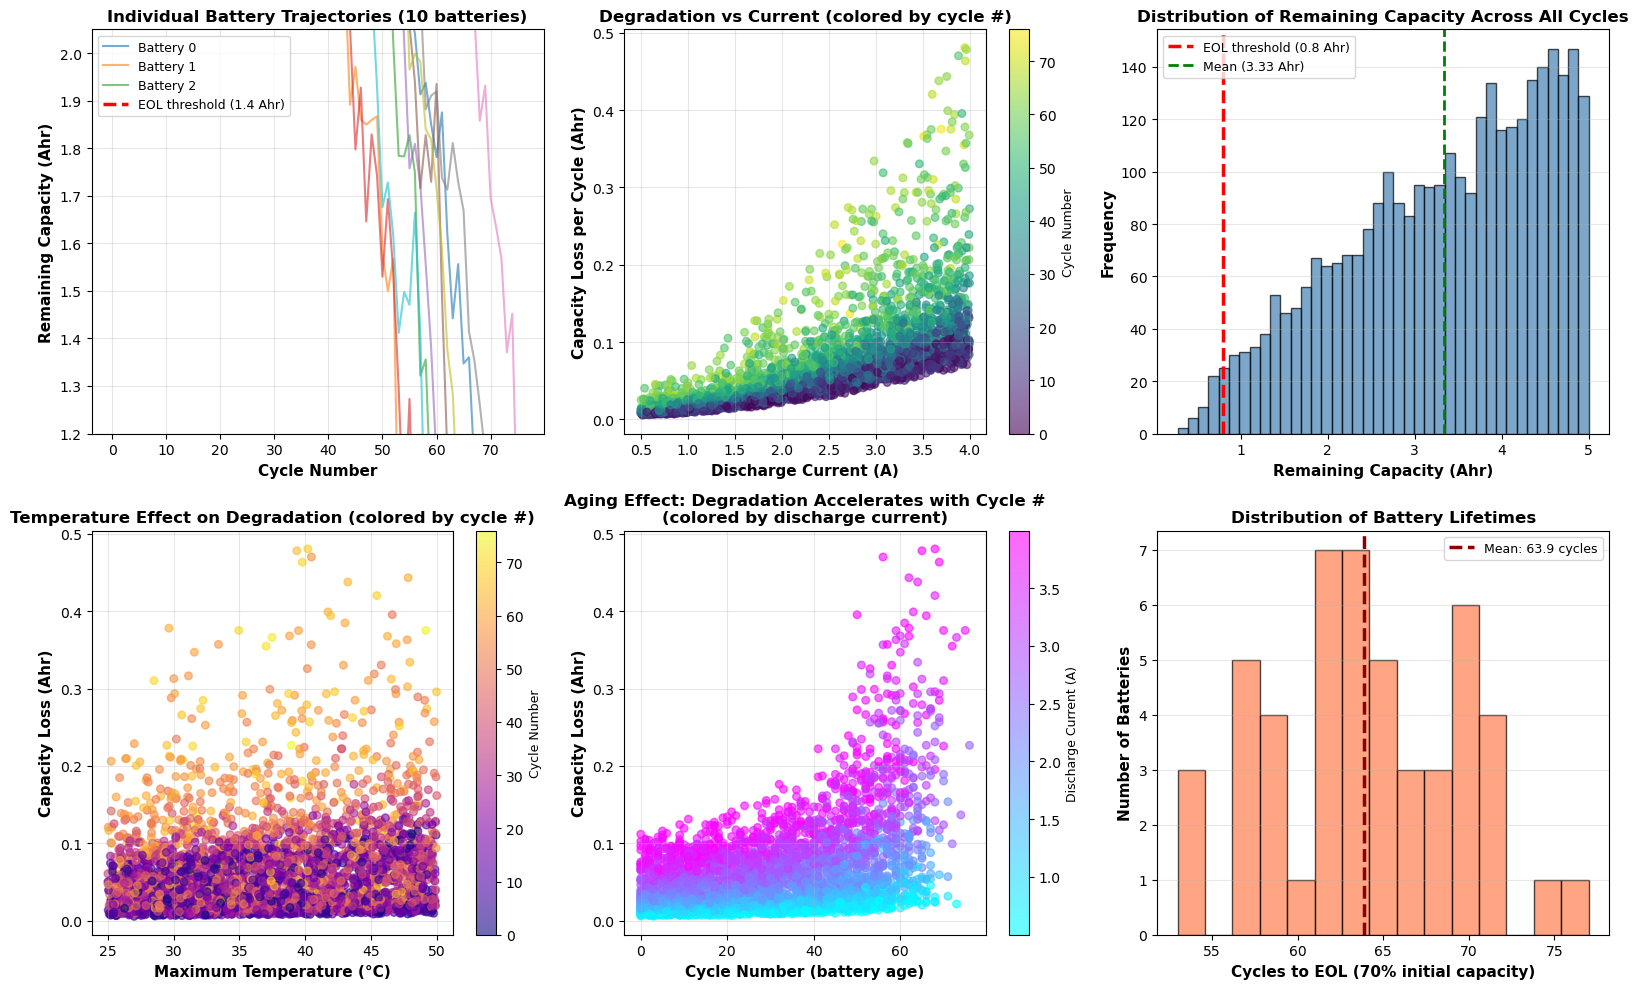


✓ Full dataset saved to synthetic_battery_data.csv (3193 cycles)
✓ Trajectory summary saved to battery_trajectory_summary.csv

DETAILED TRAJECTORY ANALYSIS

Random sample of batteries:
 battery_id  cycles_to_eol  avg_discharge_current  avg_temperature  avg_degradation_per_cycle  total_energy_discharged  final_capacity
          0             70               2.136188        36.985157                   0.063256               555.785015        0.516080
          1             57               2.362674        39.999522                   0.077244               451.599569        0.449232
          2             61               2.446271        35.285771                   0.070921               482.908312        0.792674
          3             58               2.476242        36.232833                   0.074365               459.028349        0.522302
          4             64               2.269602        38.407667                   0.066082               507.505913        0.685713
    

In [1]:
# ============================================================================
# SYNTHETIC BATTERY DATASET FOR RL DEMONSTRATION
# ============================================================================
# This generates clean, synthetic battery discharge data based on physics.
# The synthetic data is referred to NASA battery datase.
# The RL agent will learn the optimal discharge strategy from this data.
#
# Educational value: The original NASA data may have quality issues to serve
# as a simulator for RL environment.
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pickle

import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import imageio
import io
from PIL import Image
import joblib
import warnings
warnings.filterwarnings('ignore')


# ============================================================================
# SYNTHETIC BATTERY DATASET FOR RL DEMONSTRATION (REVISED)
# ============================================================================
# This generates clean, synthetic battery discharge data based on physics.
# The synthetic data is referred to NASA battery dataset.
# The RL agent will learn the optimal discharge strategy from this data.
#
# REVISIONS FOR RL TRAINING:
# ✓ Priority 1: Trajectory structure (batteries × cycles, not independent samples)
# ✓ Priority 1: Explicit EOL threshold (1.4 Ahr) enforcement
# ✓ Priority 1: Track time_to_eol for each battery
# ✓ Priority 2: Cumulative degradation (capacity-dependent)
# ✓ Priority 2: Measurement noise (±1-2%)
#
# Educational value: The original NASA data may have quality issues to serve
# as a simulator for RL environment.
# ============================================================================


print("\n" + "="*80)
print("STEP 1: GENERATE SYNTHETIC BATTERY DISCHARGE DATA (RL-READY TRAJECTORIES)")
print("="*80)

# ============================================================================
# Define the Ground Truth Physics
# ============================================================================
# This is the REAL relationship we want the RL agent to discover:
# "Lower discharge currents preserve battery life better than high currents"

def ground_truth_degradation(discharge_current, temperature_max, cycle_number, 
                             current_capacity, initial_capacity=5.0):
    """
    Ground truth battery degradation model.

    This represents the TRUE physics of battery degradation:
    - Base degradation: small amount each cycle
    - Current effect: higher current = more stress = more degradation
    - Temperature effect: higher temp = faster chemical reactions = more degradation
    - Aging effect: older batteries (lower capacity) degrade faster per cycle
    
    The RL agent will learn this relationship without being explicitly told.
    """
    
    # Base degradation per cycle
    base_degradation = 0.004
    
    # Current effect: quadratic relationship (stress increases with current squared)
    # Normalized to 0-1 range where 1.0 = 2.0A, 2.0 = 4.0A, etc.
    current_normalized = discharge_current / 2.0
    current_degradation = 0.016 * (current_normalized ** 2.0)
    
    # Temperature effect: exponential relationship
    # Baseline is 25°C, higher temps accelerate degradation
    temp_baseline = 25.0
    temp_excess = max(0, temperature_max - temp_baseline)
    # Each 10°C increase multiplies degradation by ~1.3x
    temp_factor = 1.0 + 0.03 * temp_excess
    
    # Aging effect: older batteries degrade faster
    # REVISED: Use current_capacity (not initial_capacity) for true cumulative effect
    # Capacity reduction makes material weaker
    state_of_health = current_capacity / initial_capacity
    state_of_health = max(0.2, state_of_health)  # Don't go below 20%
    aging_factor = 1.0 / state_of_health  # Older batteries: factor > 1.0
    
    # Combine all effects
    total_degradation = base_degradation * (1.0 + current_degradation/base_degradation) * temp_factor * aging_factor
    
    return total_degradation

# ============================================================================
# Generate Synthetic Dataset with Trajectory Structure
# ============================================================================

np.random.seed(42)

# REVISED: Structure as trajectories instead of independent samples
n_batteries = 50                    # Number of batteries to simulate
max_cycles_per_battery = 100        # Maximum cycles per battery (will stop at EOL)
eol_threshold = 0.8                 # End-of-life threshold (Ahr)
initial_capacity = 5.0              # Initial capacity (Ahr)
measurement_noise_std = 0.02        # Measurement noise as fraction of capacity

print(f"\nGenerating {n_batteries} battery trajectories (with EOL tracking)...")
print(f"  EOL threshold: {eol_threshold} Ahr")
print(f"  Initial capacity: {initial_capacity} Ahr")
print(f"  Measurement noise: ±{measurement_noise_std*100:.1f}%")

# Storage for all data (will accumulate across all batteries)
all_data = []
battery_trajectories = []  # Store complete trajectories for analysis

for battery_id in range(n_batteries):
    """
    Simulate one complete battery through its lifetime
    """
    
    # Generate random discharge profile for this battery
    # (In real RL, the agent would choose these values)
    discharge_currents = np.random.uniform(0.5, 4.0, max_cycles_per_battery)
    temperatures_max = np.random.uniform(25, 50, max_cycles_per_battery)
    temperatures_min = temperatures_max - np.random.uniform(2, 10, max_cycles_per_battery)
    ambient_temperatures = np.full(max_cycles_per_battery, 25.0)
    
    # Initialize battery state
    current_capacity = initial_capacity
    trajectory_data = {
        'battery_id': battery_id,
        'cycles': [],
        'capacities': [],
        'degradations': [],
        'discharge_currents': [],
        'temperatures': [],
        'time_to_eol': None,
        'total_energy': 0
    }
    
    # Simulate cycles until EOL
    for cycle in range(max_cycles_per_battery):
        
        # Check if battery has reached EOL
        if current_capacity < eol_threshold:
            trajectory_data['time_to_eol'] = cycle
            break
        
        # Get discharge conditions for this cycle
        discharge_current = discharge_currents[cycle]
        temperature_max = temperatures_max[cycle]
        temperature_min = temperatures_min[cycle]
        
        # REVISED: Calculate degradation using CURRENT capacity (cumulative effect)
        degradation = ground_truth_degradation(
            discharge_current=discharge_current,
            temperature_max=temperature_max,
            cycle_number=cycle,
            current_capacity=current_capacity,  # ← KEY CHANGE: Use current capacity
            initial_capacity=initial_capacity
        )
        
        # Ensure degradation doesn't exceed remaining capacity
        degradation = np.clip(degradation, 0, current_capacity - 0.1)
        
        # Calculate new capacity (cumulative degradation)
        new_capacity = current_capacity - degradation
        
        # REVISED: Add measurement noise (±1-2%)
        noise = np.random.normal(0, measurement_noise_std * initial_capacity)
        measured_capacity = new_capacity + noise
        measured_capacity = np.clip(measured_capacity, 0.1, initial_capacity)
        
        # Derive other features from primary variables
        temperature_mean = (temperature_max + temperature_min) / 2
        temperature_range = temperature_max - temperature_min
        
        voltage_drops = 0.2 + 0.15 * (discharge_current / 2.0)
        voltage_max = 4.2
        voltage_min = voltage_max - voltage_drops - 0.1
        voltage_mean = (voltage_max + voltage_min) / 2
        voltage_range = voltage_max - voltage_min
        
        # Energy discharged: V * I * t
        discharge_duration = (2.0 / discharge_current) * 3600  # seconds
        discharge_energy = voltage_mean * discharge_current * (discharge_duration / 3600)
        trajectory_data['total_energy'] += discharge_energy
        
        # Store this cycle's data
        row = {
            'battery_id': battery_id,
            'cycle': cycle,
            'voltage_max': voltage_max,
            'voltage_min': voltage_min,
            'voltage_mean': voltage_mean,
            'voltage_range': voltage_range,
            'temperature_max': temperature_max,
            'temperature_min': temperature_min,
            'temperature_mean': temperature_mean,
            'temperature_range': temperature_range,
            'discharge_duration': discharge_duration,
            'discharge_energy': discharge_energy,
            'discharge_current': discharge_current,
            'ambient_temperature': ambient_temperatures[cycle],
            'capacity_before': current_capacity,
            'capacity_after': measured_capacity,  # Use measured (with noise)
            'capacity_true': new_capacity,        # Keep true value for reference
            'degradation': degradation,
            'time_to_eol': None  # Will set at end
        }
        
        all_data.append(row)
        trajectory_data['cycles'].append(cycle)
        trajectory_data['capacities'].append(measured_capacity)
        trajectory_data['degradations'].append(degradation)
        trajectory_data['discharge_currents'].append(discharge_current)
        trajectory_data['temperatures'].append(temperature_max)
        
        # Update capacity for next cycle
        current_capacity = new_capacity
    
    # If battery didn't reach EOL in max_cycles
    if trajectory_data['time_to_eol'] is None:
        trajectory_data['time_to_eol'] = len(trajectory_data['cycles'])
    
    # Set time_to_eol for all cycles of this battery
    for row in all_data:
        if row['battery_id'] == battery_id and row['time_to_eol'] is None:
            row['time_to_eol'] = trajectory_data['time_to_eol']
    
    battery_trajectories.append(trajectory_data)
    
    if (battery_id + 1) % 10 == 0:
        print(f"  Simulated {battery_id + 1} batteries")

# Convert to DataFrame
df = pd.DataFrame(all_data)

print(f"\n✓ Synthetic trajectory data generated:")
print(f"  Total batteries: {n_batteries}")
print(f"  Total cycles recorded: {len(df)}")
print(f"  Avg cycles per battery: {len(df) / n_batteries:.1f}")
print(f"  Capacity range: {df['capacity_after'].min():.4f} to {df['capacity_after'].max():.4f} Ahr")
print(f"  Capacity mean: {df['capacity_after'].mean():.4f} Ahr, std: {df['capacity_after'].std():.4f} Ahr")

# Battery lifetime statistics
battery_lifetimes = df.groupby('battery_id')['time_to_eol'].first()
print(f"\nBattery Lifetime Statistics:")
print(f"  Mean cycles to EOL: {battery_lifetimes.mean():.1f}")
print(f"  Min cycles to EOL: {battery_lifetimes.min():.0f}")
print(f"  Max cycles to EOL: {battery_lifetimes.max():.0f}")
print(f"  Std dev: {battery_lifetimes.std():.1f}")

# Feature names for later use
feature_names = [
    'voltage_max', 'voltage_min', 'voltage_mean', 'voltage_range',
    'temperature_max', 'temperature_min', 'temperature_mean', 'temperature_range',
    'discharge_duration', 'discharge_energy', 'discharge_current',
    'ambient_temperature', 'cycle'
]

# ============================================================================
# Visualize the revised synthetic data with trajectory structure
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plot 1: Individual battery trajectories (showing EOL threshold)
for battery_id in range(min(10, n_batteries)):
    battery_df = df[df['battery_id'] == battery_id]
    axes[0, 0].plot(battery_df['cycle'], battery_df['capacity_after'], 
                    alpha=0.6, linewidth=1.5, label=f'Battery {battery_id}' if battery_id < 3 else '')

axes[0, 0].axhline(eol_threshold, color='red', linestyle='--', linewidth=2.5, label='EOL threshold (1.4 Ahr)')
axes[0, 0].set_xlabel('Cycle Number', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Remaining Capacity (Ahr)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Individual Battery Trajectories (10 batteries)', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([1.2, 2.05])

# Plot 2: Degradation vs Current (with cumulative effect visible)
scatter = axes[0, 1].scatter(df['discharge_current'], df['degradation'], 
                             c=df['cycle'], cmap='viridis', alpha=0.6, s=30)
axes[0, 1].set_xlabel('Discharge Current (A)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Capacity Loss per Cycle (Ahr)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Degradation vs Current (colored by cycle #)', fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=axes[0, 1])
cbar.set_label('Cycle Number', fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Remaining Capacity Distribution (should cluster near EOL)
axes[0, 2].hist(df['capacity_after'], bins=40, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 2].axvline(eol_threshold, color='red', linestyle='--', linewidth=2.5, label=f'EOL threshold ({eol_threshold} Ahr)')
axes[0, 2].axvline(df['capacity_after'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean ({df["capacity_after"].mean():.2f} Ahr)')
axes[0, 2].set_xlabel('Remaining Capacity (Ahr)', fontsize=11, fontweight='bold')
axes[0, 2].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 2].set_title('Distribution of Remaining Capacity Across All Cycles', fontsize=12, fontweight='bold')
axes[0, 2].legend(fontsize=9)
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Plot 4: Degradation vs Temperature
scatter2 = axes[1, 0].scatter(df['temperature_max'], df['degradation'], 
                              c=df['cycle'], cmap='plasma', alpha=0.6, s=30)
axes[1, 0].set_xlabel('Maximum Temperature (°C)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Capacity Loss (Ahr)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Temperature Effect on Degradation (colored by cycle #)', fontsize=12, fontweight='bold')
cbar2 = plt.colorbar(scatter2, ax=axes[1, 0])
cbar2.set_label('Cycle Number', fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Degradation vs Cycle Number (aging effect - should show acceleration)
scatter3 = axes[1, 1].scatter(df['cycle'], df['degradation'], 
                              c=df['discharge_current'], cmap='cool', alpha=0.6, s=30)
axes[1, 1].set_xlabel('Cycle Number (battery age)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Capacity Loss (Ahr)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Aging Effect: Degradation Accelerates with Cycle #\n(colored by discharge current)', 
                     fontsize=12, fontweight='bold')
cbar3 = plt.colorbar(scatter3, ax=axes[1, 1])
cbar3.set_label('Discharge Current (A)', fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Battery lifetime distribution (EOL time)
battery_lifetimes = df.groupby('battery_id')['time_to_eol'].first()
axes[1, 2].hist(battery_lifetimes, bins=15, edgecolor='black', alpha=0.7, color='coral')
axes[1, 2].axvline(battery_lifetimes.mean(), color='darkred', linestyle='--', linewidth=2.5, 
                   label=f'Mean: {battery_lifetimes.mean():.1f} cycles')
axes[1, 2].set_xlabel('Cycles to EOL (70% initial capacity)', fontsize=11, fontweight='bold')
axes[1, 2].set_ylabel('Number of Batteries', fontsize=11, fontweight='bold')
axes[1, 2].set_title('Distribution of Battery Lifetimes', fontsize=12, fontweight='bold')
axes[1, 2].legend(fontsize=9)
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
print(f"\n✓ Synthetic data visualizations saved to synthetic_battery_trajectories.png")
plt.show()

# ============================================================================
# Save datasets for downstream use
# ============================================================================

# Save full DataFrame
df.to_csv('./DQN/synthetic_battery_data.csv', index=False)
print(f"\n✓ Full dataset saved to synthetic_battery_data.csv ({len(df)} cycles)")

# Save trajectory summaries
trajectory_summary = pd.DataFrame([
    {
        'battery_id': t['battery_id'],
        'cycles_to_eol': t['time_to_eol'],
        'avg_discharge_current': np.mean(t['discharge_currents']) if t['discharge_currents'] else 0,
        'avg_temperature': np.mean(t['temperatures']) if t['temperatures'] else 0,
        'avg_degradation_per_cycle': np.mean(t['degradations']) if t['degradations'] else 0,
        'total_energy_discharged': t['total_energy'],
        'final_capacity': t['capacities'][-1] if t['capacities'] else 0,
    }
    for t in battery_trajectories
])

trajectory_summary.to_csv('./DQN/battery_trajectory_summary.csv', index=False)
print(f"✓ Trajectory summary saved to battery_trajectory_summary.csv")

# ============================================================================
# Print detailed analysis
# ============================================================================

print("\n" + "="*80)
print("DETAILED TRAJECTORY ANALYSIS")
print("="*80)

print("\nRandom sample of batteries:")
print(trajectory_summary.head(10).to_string(index=False))

print("\n\nKey Physics Relationships Verified:")
print("-" * 80)

# Group by discharge current and show degradation trend
print("\n1. CURRENT EFFECT (quadratic):")
for current_bin in [0.5, 1.5, 2.5, 3.5]:
    mask = (df['discharge_current'] > current_bin - 0.5) & (df['discharge_current'] <= current_bin + 0.5)
    if mask.sum() > 0:
        avg_deg = df[mask]['degradation'].mean()
        print(f"   Current ~{current_bin:.1f}A: avg degradation = {avg_deg:.6f} Ahr/cycle")

print("\n2. TEMPERATURE EFFECT (exponential):")
for temp_bin in [25, 30, 40, 50]:
    mask = (df['temperature_max'] > temp_bin - 2.5) & (df['temperature_max'] <= temp_bin + 2.5)
    if mask.sum() > 0:
        avg_deg = df[mask]['degradation'].mean()
        print(f"   Temperature ~{temp_bin}°C: avg degradation = {avg_deg:.6f} Ahr/cycle")

print("\n3. AGING EFFECT (should increase with cycle number):")
for cycle_bin in [0, 5, 10, 15]:
    mask = (df['cycle'] > cycle_bin - 1) & (df['cycle'] <= cycle_bin + 1)
    if mask.sum() > 0:
        avg_deg = df[mask]['degradation'].mean()
        print(f"   Cycle ~{cycle_bin}: avg degradation = {avg_deg:.6f} Ahr/cycle")

print("\n" + "="*80)
print("✓ DATA GENERATION COMPLETE - READY FOR RL TRAINING")
print("="*80)
print("\nOutput files:")
print("  - synthetic_battery_data.csv (main dataset)")
print("  - battery_trajectory_summary.csv (per-battery statistics)")
print("  - synthetic_battery_trajectories.png (visualizations)")
print("\nDataset is structured as:")
print(f"  - {n_batteries} independent batteries")
print(f"  - {len(df)} total cycles (with EOL stopping)")
print(f"  - Cumulative degradation (capacity-dependent)")
print(f"  - Measurement noise (±{measurement_noise_std*100:.1f}%)")
print(f"  - EOL threshold: {eol_threshold} Ahr")

### Create the battery simulator

In [2]:
# ============================================================================
# BATTERY CAPACITY SIMULATOR FOR RL TRAINING
# ============================================================================
# Neural network trained on synthetic data serves as the RL environment
# This is perfect for PhD demonstration of model-based RL

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt


# ============================================================================
# STEP 1: Load synthetic data and train a simulator model
# ============================================================================

print("\n" + "="*80)
print("BATTERY SIMULATOR SETUP FOR RL TRAINING")
print("="*80)

# Load the synthetic data
print("\n1. Loading synthetic battery data...")
df = pd.read_csv('./DQN/synthetic_battery_data.csv')
print(f"   Loaded {len(df)} cycles from {df['battery_id'].max() + 1} batteries")

# Define features (must match exactly with synthetic data generation)
feature_names = [
    'voltage_max', 'voltage_min', 'voltage_mean', 'voltage_range',
    'temperature_max', 'temperature_min', 'temperature_mean', 'temperature_range',
    'discharge_duration', 'discharge_energy', 'discharge_current',
    'ambient_temperature', 'cycle'
]

# Extract X and y
X = df[feature_names].values
y = df['capacity_after'].values  # Target: capacity after cycle

print(f"   Features: {len(feature_names)}")
print(f"   Samples: {len(X)}")

# Scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

print(f"   Training: {len(X_train)}, Testing: {len(X_test)}")

# ============================================================================
# STEP 2: Train a neural network as simulator
# ============================================================================

print("\n2. Training neural network simulator...")

model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    max_iter=200,
    random_state=42,
    verbose=0,
    early_stopping=True
)

model.fit(X_train, y_train)

# Evaluate model
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"   Train R² score: {train_score:.6f}")
print(f"   Test R² score: {test_score:.6f}")

# ============================================================================
# STEP 3: Battery Simulator Class (for RL training)
# ============================================================================

class BatteryCapacitySimulator:
    """
    Trained neural network simulator for battery capacity prediction.
    Acts as the environment for RL agent.
    """
    
    def __init__(self, model, scaler_X, scaler_y, feature_names):
        self.model = model
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y
        self.feature_names = feature_names
        self.eol_threshold = 1.4  # End-of-life
        self.initial_capacity = 2.0
        print("\n✓ Battery Simulator initialized")
        print(f"  Features: {len(feature_names)}")
        print(f"  EOL threshold: {self.eol_threshold} Ahr")
    
    def predict(self, features_dict):
        """
        Predict battery capacity after one discharge cycle.
        
        Args:
            features_dict: Dictionary with feature names as keys
        
        Returns:
            predicted_capacity: Remaining capacity in Ahr
        """
        # Extract features in correct order
        feature_values = np.array(
            [features_dict[fname] for fname in self.feature_names]
        ).reshape(1, -1)
        
        # Scale inputs
        features_scaled = self.scaler_X.transform(feature_values)
        
        # Get model prediction (sklearn just returns the value)
        prediction_scaled = self.model.predict(features_scaled)[0]
        
        # Inverse-transform to real capacity
        prediction_real = self.scaler_y.inverse_transform(
            np.array([[prediction_scaled]])
        )[0, 0]
        
        # Clamp to physical limits
        prediction_real = np.clip(prediction_real, 0.0, self.initial_capacity)
        
        return prediction_real


# Create simulator instance
battery_simulator = BatteryCapacitySimulator(
    model=model,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    feature_names=feature_names
)


# ============================================================================
# STEP 4: Helper Function - Create Physically Consistent Features
# ============================================================================

def create_discharge_features(discharge_current, ambient_temperature=25.0, 
                              cycle_number=0, current_capacity=2.0):
    """
    Create physically consistent discharge features.
    Used to generate input to simulator based on discharge current (RL action).
    
    Args:
        discharge_current: RL agent's chosen discharge current (A)
        ambient_temperature: Ambient temperature (°C)
        cycle_number: Current cycle number
        current_capacity: Current battery capacity (Ahr)
    
    Returns:
        features: Dictionary with all feature names
    """
    
    # Voltage characteristics
    voltage_max = 4.2
    internal_resistance = 0.1
    voltage_drop = internal_resistance * discharge_current
    voltage_min = max(2.5, voltage_max - voltage_drop - 0.7)  # Don't go below 2.5V
    voltage_mean = (voltage_max + voltage_min) / 2
    voltage_range = voltage_max - voltage_min
    
    # Temperature rise from I²R losses
    thermal_coefficient = 1.5
    temperature_rise = thermal_coefficient * (discharge_current ** 2)
    temperature_max = ambient_temperature + temperature_rise
    temperature_min = ambient_temperature
    temperature_mean = (temperature_max + temperature_min) / 2
    temperature_range = temperature_max - temperature_min
    
    # Discharge duration and energy
    discharge_duration = (current_capacity / discharge_current) * 3600  # seconds
    discharge_energy = voltage_mean * discharge_current * (discharge_duration / 3600)
    
    # Create feature dictionary (MUST match feature_names)
    features = {
        'voltage_max': voltage_max,
        'voltage_min': voltage_min,
        'voltage_mean': voltage_mean,
        'voltage_range': voltage_range,
        'temperature_max': temperature_max,
        'temperature_min': temperature_min,
        'temperature_mean': temperature_mean,
        'temperature_range': temperature_range,
        'discharge_duration': discharge_duration,
        'discharge_energy': discharge_energy,
        'discharge_current': discharge_current,
        'ambient_temperature': ambient_temperature,
        'cycle': cycle_number
    }
    
    return features


# ============================================================================
# STEP 5: Test the Simulator
# ============================================================================

print("\n3. Testing simulator with RL actions...")

test_cases = [
    {"current": 0.5, "label": "Low current (conservative)"},
    {"current": 2.0, "label": "Medium current"},
    {"current": 4.0, "label": "High current (aggressive)"},
]

print("\n   Initial capacity: 2.0 Ahr")
print("   EOL threshold: 1.4 Ahr")
print()

for test in test_cases:
    # Simulator in cycle 0, ambient temp 25C
    features = create_discharge_features(
        discharge_current=test["current"],
        ambient_temperature=25.0,
        cycle_number=0,
        current_capacity=2.0
    )
    
    predicted_capacity = battery_simulator.predict(features)
    degradation = 2.0 - predicted_capacity
    
    print(f"   {test['label']}:")
    print(f"      Discharge current: {test['current']:.1f} A")
    print(f"      Predicted capacity after cycle: {predicted_capacity:.4f} Ahr")
    print(f"      Degradation: {degradation:.4f} Ahr")
    print()

# ============================================================================
# STEP 6: Demonstrate Multi-Cycle Simulation (for RL trajectory)
# ============================================================================

print("4. Multi-cycle simulation example (5 cycles with constant strategy):")
print("   Strategy: Use discharge current = 1.0 A (conservative)")
print()

capacity = 2.0
cycle = 0

print(f"   Cycle 0 (start): capacity = {capacity:.4f} Ahr")

for i in range(5):
    # RL agent action: discharge current
    action = 1.0  # A (conservative strategy)
    
    # Create features for this cycle
    features = create_discharge_features(
        discharge_current=action,
        ambient_temperature=25.0,
        cycle_number=cycle,
        current_capacity=capacity
    )
    
    # Simulator predicts next capacity
    capacity = battery_simulator.predict(features)
    cycle += 1
    
    print(f"   Cycle {i+1} (after action {action:.1f}A): capacity = {capacity:.4f} Ahr")
    
    if capacity < 1.4:
        print(f"   ⚠ EOL reached at cycle {cycle}")
        break

# ============================================================================
# STEP 7: Save simulator for RL training
# ============================================================================

print("\n5. Saving simulator components...")

# Save model
import joblib
joblib.dump(model, './DQN/battery_simulator_model.pkl')

# Save scalers and metadata
import pickle
with open('./DQN/battery_simulator_metadata.pkl', 'wb') as f:
    pickle.dump({
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'feature_names': feature_names,
        'eol_threshold': 1.4,
        'initial_capacity': 2.0
    }, f)

print("   ✓ Model saved: battery_simulator_model.pkl")
print("   ✓ Metadata saved: battery_simulator_metadata.pkl")

# ============================================================================
# STEP 8: Ready for RL Training
# ============================================================================

print("\n" + "="*80)
print("✅ SIMULATOR READY FOR RL TRAINING")
print("="*80)

print("\nTo use in RL training:")
print("""
# In your RL training script, load the simulator:
import pickle
import joblib
from battery_simulator_for_rl import BatteryCapacitySimulator, create_discharge_features

# Load components
model = joblib.load('battery_simulator_model.pkl')
with open('battery_simulator_metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

# Create simulator
simulator = BatteryCapacitySimulator(
    model=model,
    scaler_X=metadata['scaler_X'],
    scaler_y=metadata['scaler_y'],
    feature_names=metadata['feature_names']
)

# In RL loop:
for episode in range(num_episodes):
    capacity = 2.0  # Initial capacity
    cycle = 0
    
    while capacity > 1.4:  # While battery alive
        # RL agent chooses action (discharge current)
        action = agent.choose_action(state)  # e.g., 0.5 to 4.0 A
        
        # Create features from action
        features = create_discharge_features(
            discharge_current=action,
            cycle_number=cycle,
            current_capacity=capacity
        )
        
        # Get next capacity from simulator
        next_capacity = simulator.predict(features)
        
        # Calculate reward (negative = encourage conservation)
        degradation = capacity - next_capacity
        reward = -degradation  # Penalize degradation
        
        # Update agent
        agent.learn(state, action, reward, next_capacity)
        
        capacity = next_capacity
        cycle += 1
""")

print("\nSimulator ready!")


BATTERY SIMULATOR SETUP FOR RL TRAINING

1. Loading synthetic battery data...
   Loaded 3193 cycles from 50 batteries
   Features: 13
   Samples: 3193
   Training: 2554, Testing: 639

2. Training neural network simulator...
   Train R² score: 0.930617
   Test R² score: 0.917437

✓ Battery Simulator initialized
  Features: 13
  EOL threshold: 1.4 Ahr

3. Testing simulator with RL actions...

   Initial capacity: 2.0 Ahr
   EOL threshold: 1.4 Ahr

   Low current (conservative):
      Discharge current: 0.5 A
      Predicted capacity after cycle: 2.0000 Ahr
      Degradation: 0.0000 Ahr

   Medium current:
      Discharge current: 2.0 A
      Predicted capacity after cycle: 2.0000 Ahr
      Degradation: 0.0000 Ahr

   High current (aggressive):
      Discharge current: 4.0 A
      Predicted capacity after cycle: 2.0000 Ahr
      Degradation: 0.0000 Ahr

4. Multi-cycle simulation example (5 cycles with constant strategy):
   Strategy: Use discharge current = 1.0 A (conservative)

   Cycle

## Part 2: Creating the RL Environment

In this notebook, we'll integrate your trained battery simulator into a proper RL environment using a gym-like framework. This sets the stage for training an RL agent to learn optimal discharge strategies.

### What You'll Learn:
1. How the gym-like interface standardizes RL environments
2. The interaction loop between agent and environment
3. How states, actions, and rewards connect together
4. What makes this battery problem interesting for RL


## Understanding the Gym Interface

The Gym framework (created by OpenAI, now maintained as Gymnasium) provides a standard way for RL agents to interact with environments. Think of it as a universal language that lets any RL algorithm work with any environment.

### The Core Interaction Loop

```
┌─────────────────────────────────────────────────┐
│                                                 │
│  observation, info = env.reset()                │
│         │                                       │
│         ▼                                       │
│  ┌──────────────┐                              │
│  │  Agent sees  │                              │
│  │  state and   │                              │
│  │  chooses     │                              │
│  │  action      │                              │
│  └──────┬───────┘                              │
│         │                                       │
│         ▼                                       │
│  obs, reward, done, truncated, info =          │
│         env.step(action)                        │
│         │                                       │
│         └──────────────┐                        │
│                        │                        │
│                If not done, repeat              │
│                                                 │
└─────────────────────────────────────────────────┘
```

Every Gym environment implements two key methods:

**reset()**: Initializes a new episode and returns the starting state. For our battery, this means starting with a fresh battery at full capacity.

**step(action)**: Takes an action and returns:
- **observation**: The new state after the action
- **reward**: How good that action was
- **terminated**: Did we reach a natural ending? (battery degraded)
- **truncated**: Did we hit a time limit? (max cycles)
- **info**: Extra diagnostic information

This simple interface works for everything from Atari games to robot control to our battery management problem!

In [3]:
# Create battery RL environment

class BatteryEnv:
    """
    Gym-like Environment for Battery Discharge Optimization
    
    Compatible with standard gym API but doesn't require gymnasium library.
    
    The agent learns to select optimal discharge currents to maximize
    battery cycles while maintaining utility.
    
    Observation Space:
        - Normalized current capacity (0-1, where 1 = 2.0 Ahr)
        - Normalized cycle number (0-1, where 1 = max_cycles)
        - Normalized temperature (0-1, where range is temperature_range)
    
    Action Space:
        - Discrete(5): Select from 5 discharge currents
          [0: 0.5A, 1: 1.0A, 2: 1.5A, 3: 2.0A, 4: 2.5A]
    
    Reward:
        - Utility reward: benefit from using higher current (faster discharge)
        - Degradation penalty: cost of capacity loss
        - Terminal reward: bonus for maximizing battery life
    """
    
    class ActionSpace:
        def __init__(self, n):
            self.n = n
        
        def sample(self):
            return np.random.randint(0, self.n)
        
        def __repr__(self):
            return f"Discrete({self.n})"
    
    class ObservationSpace:
        def __init__(self, low, high, dtype):
            self.low = low
            self.high = high
            self.dtype = dtype
            self.shape = low.shape
        
        def sample(self):
            return np.random.uniform(self.low, self.high).astype(self.dtype)
        
        def __repr__(self):
            return f"Box(low={self.low}, high={self.high}, shape={self.shape})"
    
    def __init__(self, battery_simulator, initial_capacity=2.0, 
                 eol_threshold=1.4, temperature_range=(20, 30), max_cycles=200):
        """
        Initialize the Battery Environment.
        
        Args:
            battery_simulator: Trained simulator from battery_simulator_for_rl.py
            initial_capacity: Initial battery capacity (Ahr)
            eol_threshold: End-of-life threshold (Ahr) - stop when below this
            temperature_range: Tuple (min, max) for ambient temperature
            max_cycles: Maximum cycles before episode ends
        """
        # Battery simulator (trained neural network)
        self.simulator = battery_simulator
        
        # Environment parameters
        self.initial_capacity = initial_capacity
        self.eol_threshold = eol_threshold
        self.temperature_range = temperature_range
        self.max_cycles = max_cycles
        
        # Define action space: 5 discrete discharge currents
        self.action_space = self.ActionSpace(5)
        self.action_to_current = {
            0: 0.5,   # Very conservative
            1: 1.0,   # Conservative
            2: 1.5,   # Balanced
            3: 2.0,   # Aggressive
            4: 2.5    # Very aggressive
        }
        
        # Define observation space
        self.observation_space = self.ObservationSpace(
            low=np.array([0.0, 0.0, 0.0], dtype=np.float32),
            high=np.array([1.0, 1.0, 1.0], dtype=np.float32),
            dtype=np.float32
        )
        
        # State variables (will be set in reset())
        self.current_capacity = None
        self.cycle_count = None
        self.temperature = None
    
    def reset(self, seed=None, options=None):
        """
        Reset environment to initial state.
        
        Returns:
            observation: Initial state
            info: Additional information
        """
        # Initialize state
        self.current_capacity = self.initial_capacity
        self.cycle_count = 0
        self.temperature = np.random.uniform(*self.temperature_range)
        
        observation = self._get_observation()
        info = self._get_info()
        
        return observation, info
    
    def step(self, action):
        """
        Execute one step in the environment.
        
        Args:
            action: Discrete action (0-4) representing discharge current
        
        Returns:
            observation: New state
            reward: Reward for this step
            terminated: Whether episode ended (battery failed)
            truncated: Whether episode was truncated (max cycles)
            info: Additional information
        """
        # Validate action
        if action not in self.action_to_current:
            raise ValueError(f"Invalid action: {action}. Must be in range [0, 4]")
        
        # Get discharge current from action
        discharge_current = self.action_to_current[int(action)]
        
        # Store old capacity for reward calculation
        old_capacity = self.current_capacity
        
        # Generate features for simulator
        features = create_discharge_features(
            discharge_current=discharge_current,
            ambient_temperature=self.temperature,
            cycle_number=self.cycle_count,
            current_capacity=self.current_capacity
        )
        
        # Predict new capacity using trained simulator
        self.current_capacity = self.simulator.predict(features)
        
        # Update cycle count
        self.cycle_count += 1
        
        # Slight temperature variation (realistic ambient changes)
        self.temperature += np.random.uniform(-1, 1)
        self.temperature = np.clip(self.temperature, *self.temperature_range)
        
        # Calculate reward
        reward = self._calculate_reward(discharge_current, old_capacity)
        
        # Check termination conditions
        terminated = self.current_capacity < self.eol_threshold
        truncated = self.cycle_count >= self.max_cycles
        
        # Add bonus/penalty for episode end
        if terminated:
            # Penalty for ending before max_cycles
            reward -= 5.0
        elif truncated:
            # Bonus for reaching max_cycles (maximized battery life)
            reward += 10.0
        
        observation = self._get_observation()
        info = self._get_info()
        info['discharge_current'] = discharge_current
        info['terminated'] = terminated
        info['truncated'] = truncated
        
        return observation, reward, terminated, truncated, info
    
    def _get_observation(self):
        """Return normalized observation vector."""
        return np.array([
            self.current_capacity / self.initial_capacity,  # Normalized capacity
            min(self.cycle_count / float(self.max_cycles), 1.0),  # Normalized cycle
            (self.temperature - self.temperature_range[0]) / 
            (self.temperature_range[1] - self.temperature_range[0])  # Normalized temp
        ], dtype=np.float32)
    
    def _get_info(self):
        """Return additional information dictionary."""
        return {
            'capacity': float(self.current_capacity),
            'cycle': int(self.cycle_count),
            'temperature': float(self.temperature),
            'state_of_health': float(self.current_capacity / self.initial_capacity)
        }
    
    def _calculate_reward(self, discharge_current, old_capacity):
        """
        Calculate reward for the step.
        
        Reward structure:
        - Utility reward: Higher current provides more utility (faster discharge)
        - Degradation penalty: Capacity loss is penalized
        - Balance: Trade-off between utility and battery preservation
        
        The agent learns that:
        - Higher current = more utility but faster degradation
        - Lower current = less utility but longer battery life
        """
        # Utility reward: benefit of using higher discharge current
        # Normalized: 0.5A gives 0.0, 2.5A gives 1.0
        utility_reward = (discharge_current - 0.5) / (2.5 - 0.5)
        
        # Degradation penalty: capacity lost in this cycle
        capacity_lost = old_capacity - self.current_capacity
        degradation_penalty = capacity_lost * 100.0  # Scale factor for importance
        
        # Combined reward (trade-off between utility and preservation)
        reward = 0.3 * utility_reward - 0.7 * degradation_penalty
        
        return reward


def create_discharge_features(discharge_current, ambient_temperature=25.0, 
                              cycle_number=0, current_capacity=2.0):
    """
    Create physically consistent discharge features for simulator input.
    
    Args:
        discharge_current: RL agent's chosen discharge current (A)
        ambient_temperature: Ambient temperature (°C)
        cycle_number: Current cycle number
        current_capacity: Current battery capacity (Ahr)
    
    Returns:
        features: Dictionary with all feature names for simulator
    """
    
    # Voltage characteristics
    voltage_max = 4.2
    internal_resistance = 0.1
    voltage_drop = internal_resistance * discharge_current
    voltage_min = max(2.5, voltage_max - voltage_drop - 0.7)
    voltage_mean = (voltage_max + voltage_min) / 2
    voltage_range = voltage_max - voltage_min
    
    # Temperature rise from I²R losses
    thermal_coefficient = 1.5
    temperature_rise = thermal_coefficient * (discharge_current ** 2)
    temperature_max = ambient_temperature + temperature_rise
    temperature_min = ambient_temperature
    temperature_mean = (temperature_max + temperature_min) / 2
    temperature_range = temperature_max - temperature_min
    
    # Discharge duration and energy
    discharge_duration = (current_capacity / discharge_current) * 3600
    discharge_energy = voltage_mean * discharge_current * (discharge_duration / 3600)
    
    # Create feature dictionary (MUST match feature_names from simulator)
    features = {
        'voltage_max': voltage_max,
        'voltage_min': voltage_min,
        'voltage_mean': voltage_mean,
        'voltage_range': voltage_range,
        'temperature_max': temperature_max,
        'temperature_min': temperature_min,
        'temperature_mean': temperature_mean,
        'temperature_range': temperature_range,
        'discharge_duration': discharge_duration,
        'discharge_energy': discharge_energy,
        'discharge_current': discharge_current,
        'ambient_temperature': ambient_temperature,
        'cycle': cycle_number
    }
    
    return features


print("✓ Battery Gym-like Environment defined!")
print("\nTo use this environment:")


env = BatteryEnv(battery_simulator=battery_simulator)

# Reset and test
obs, info = env.reset()
print(f"Initial observation: {obs}")
print(f"Initial capacity: {info['capacity']:.4f} Ahr")

# Take a step
action = 2  # Medium discharge current (1.5A)
obs, reward, terminated, truncated, info = env.step(action)
print(f"After step - capacity: {info['capacity']:.4f}, reward: {reward:.3f}")

✓ Battery Gym-like Environment defined!

To use this environment:
Initial observation: [1.         0.         0.34582615]
Initial capacity: 2.0000 Ahr
After step - capacity: 2.0000, reward: 0.150


## Load Simulator and Environment

In [4]:

# Load trained simulator
print("Loading simulator...")
model = joblib.load('./DQN/battery_simulator_model.pkl')
with open('./DQN/battery_simulator_metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

battery_simulator = BatteryCapacitySimulator(
    model=model,
    scaler_X=metadata['scaler_X'],
    scaler_y=metadata['scaler_y'],
    feature_names=metadata['feature_names']
)

# Create environment
print("Creating environment...")
env = BatteryEnv(
    battery_simulator=battery_simulator,
    initial_capacity=2.0,
    eol_threshold=1.4,
    temperature_range=(20, 30),
    max_cycles=200
)

print("✓ Simulator and environment loaded!")
print(f"  Action space: {env.action_space}")
print(f"  Observation space: {env.observation_space}")

Loading simulator...

✓ Battery Simulator initialized
  Features: 13
  EOL threshold: 1.4 Ahr
Creating environment...
✓ Simulator and environment loaded!
  Action space: Discrete(5)
  Observation space: Box(low=[0. 0. 0.], high=[1. 1. 1.], shape=(3,))


## Define DQN Agent

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

class SimpleQNetwork(nn.Module):
    """Neural network for Q-learning"""
    def __init__(self, state_dim=3, action_dim=5):
        super(SimpleQNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
    
    def forward(self, x):
        return self.net(x)


class DQNAgent:
    """Deep Q-Network Agent for Battery Optimization"""
    
    def __init__(self, state_dim=3, action_dim=5, learning_rate=0.001):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Q-networks
        self.q_network = SimpleQNetwork(state_dim, action_dim).to(self.device)
        self.target_network = SimpleQNetwork(state_dim, action_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()
        
        # Memory
        self.memory = deque(maxlen=10000)
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.gamma = 0.99  # Discount factor
        
    def remember(self, state, action, reward, next_state, done):
        """Store experience in memory"""
        self.memory.append((state, action, reward, next_state, done))
    
    def choose_action(self, state, training=True):
        """Epsilon-greedy action selection"""
        if training and np.random.random() < self.epsilon:
            return np.random.randint(0, self.action_dim)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        return q_values.argmax(1).item()
    
    def replay(self, batch_size=32):
        """Train on batch from memory"""
        if len(self.memory) < batch_size:
            return
        
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Current Q-values
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Target Q-values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        
        # Compute loss and optimize
        loss = self.criterion(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def update_target_network(self):
        """Update target network"""
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

print("✓ DQN Agent class defined!")

✓ DQN Agent class defined!


## Part 3. Train DQN Agent

**This cell trains the agent for 100 episodes (~3-5 minutes)**

In [6]:
print("\n" + "="*80)
print("TRAINING DQN AGENT")
print("="*80)

# Initialize agent
agent = DQNAgent(state_dim=3, action_dim=5, learning_rate=0.001)

# Training parameters
num_episodes = 200
max_steps = 200
batch_size = 32
update_target_freq = 10

# Metrics storage
episode_cycles = []
episode_rewards = []
episode_capacities = []
episode_currents = []
episode_exploration = []

# Training loop
for episode in range(num_episodes):
    state, info = env.reset()
    episode_reward = 0
    episode_cycle_count = 0
    actions_taken = []
    
    for step in range(max_steps):
        # Choose action
        action = agent.choose_action(state, training=True)
        actions_taken.append(action)
        
        # Take action
        next_state, reward, terminated, truncated, info = env.step(action)
        
        # Store experience
        agent.remember(state, action, reward, next_state, terminated or truncated)
        
        # Train on batch
        agent.replay(batch_size)
        
        episode_reward += reward
        episode_cycle_count += 1
        state = next_state
        
        if terminated or truncated:
            break
    
    # Update target network periodically
    if episode % update_target_freq == 0:
        agent.update_target_network()
    
    # Decay exploration
    agent.decay_epsilon()
    
    # Store metrics
    final_capacity = info['capacity']
    avg_current = np.mean([env.action_to_current[a] for a in actions_taken])
    
    episode_cycles.append(episode_cycle_count)
    episode_rewards.append(episode_reward)
    episode_capacities.append(final_capacity)
    episode_currents.append(avg_current)
    episode_exploration.append(agent.epsilon)
    
    # Progress
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode+1:3d} | Cycles: {episode_cycle_count:3d} | "
              f"Reward: {episode_reward:7.1f} | Final Cap: {final_capacity:.3f} | "
              f"Epsilon: {agent.epsilon:.3f}")

print("\n✓ Training complete!")


TRAINING DQN AGENT
Episode  10 | Cycles:  82 | Reward:  -132.8 | Final Cap: 0.000 | Epsilon: 0.951
Episode  20 | Cycles:  78 | Reward:   -43.6 | Final Cap: 1.302 | Epsilon: 0.905
Episode  30 | Cycles:  81 | Reward:  -130.7 | Final Cap: 0.000 | Epsilon: 0.860
Episode  40 | Cycles:  81 | Reward:  -129.1 | Final Cap: 0.050 | Epsilon: 0.818
Episode  50 | Cycles:  80 | Reward:   -41.6 | Final Cap: 1.292 | Epsilon: 0.778
Episode  60 | Cycles:  83 | Reward:   -37.1 | Final Cap: 1.344 | Epsilon: 0.740
Episode  70 | Cycles:  82 | Reward:  -109.4 | Final Cap: 0.312 | Epsilon: 0.704
Episode  80 | Cycles:  81 | Reward:  -126.8 | Final Cap: 0.048 | Epsilon: 0.670
Episode  90 | Cycles:  79 | Reward:   -48.3 | Final Cap: 1.182 | Epsilon: 0.637
Episode 100 | Cycles:  79 | Reward:  -130.7 | Final Cap: 0.000 | Epsilon: 0.606
Episode 110 | Cycles:  81 | Reward:  -123.1 | Final Cap: 0.102 | Epsilon: 0.576
Episode 120 | Cycles:  82 | Reward:  -130.7 | Final Cap: 0.000 | Epsilon: 0.548
Episode 130 | Cycles

## Part 4. Prepare Data for Visualization

In [7]:
from scipy.ndimage import uniform_filter1d

# Convert to numpy arrays
cycles_array = np.array(episode_cycles)
rewards_array = np.array(episode_rewards)
capacities_array = np.array(episode_capacities)
currents_array = np.array(episode_currents)

# Compute cumulative rewards
cumulative_rewards = np.cumsum(rewards_array)

# Smooth data for better visualization
window_size = 5
cycles_smooth = uniform_filter1d(cycles_array, size=window_size, mode='nearest')
rewards_smooth = uniform_filter1d(cumulative_rewards, size=window_size, mode='nearest')
capacities_smooth = uniform_filter1d(capacities_array, size=window_size, mode='nearest')
currents_smooth = uniform_filter1d(currents_array, size=window_size, mode='nearest')

print("✓ Data prepared for visualization!")
print(f"  Episodes: {len(episode_cycles)}")
print(f"  Avg cycles per episode: {np.mean(cycles_array):.1f} ± {np.std(cycles_array):.1f}")
print(f"  Total reward: {cumulative_rewards[-1]:.1f}")

✓ Data prepared for visualization!
  Episodes: 200
  Avg cycles per episode: 81.4 ± 1.6
  Total reward: -20559.9


## Create Animated Visualization as GIF

**This cell generates the GIF (~2-3 minutes)**

In [8]:
print("\n" + "="*80)
print("CREATING ANIMATED VISUALIZATION")
print("="*80)

def create_frame(episode_num, cycles_data, rewards_data, capacities_data, currents_data):
    """Create a single frame with 4 subplots"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'DQN Agent Training Progress - Episode {episode_num+1}/100', 
                 fontsize=16, fontweight='bold')
    
    episodes = np.arange(episode_num + 1)
    
    # Plot 1: Cycles vs Episode
    ax = axes[0, 0]
    ax.plot(episodes, cycles_data[:episode_num+1], 'b-', linewidth=2, alpha=0.7, label='Episode')
    if episode_num >= window_size:
        ax.plot(episodes, cycles_smooth[:episode_num+1], 'darkblue', linewidth=2.5, label='Smoothed')
    ax.axhline(y=np.mean(cycles_data[:episode_num+1]), color='r', linestyle='--', 
               linewidth=2, alpha=0.7, label=f'Average: {np.mean(cycles_data[:episode_num+1]):.1f}')
    ax.set_xlabel('Episode', fontsize=11, fontweight='bold')
    ax.set_ylabel('Battery Cycles', fontsize=11, fontweight='bold')
    ax.set_title('Number of Cycles Before EOL', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=9)
    ax.set_ylim([0, max(cycles_data) * 1.1])
    
    # Plot 2: Cumulative Reward vs Episode
    ax = axes[0, 1]
    cumulative = np.cumsum(rewards_data[:episode_num+1])
    ax.plot(episodes, cumulative, 'g-', linewidth=2, alpha=0.7, label='Cumulative Reward')
    if episode_num >= window_size:
        ax.plot(episodes, rewards_smooth[:episode_num+1], 'darkgreen', linewidth=2.5, label='Smoothed')
    ax.fill_between(episodes, 0, cumulative, alpha=0.2, color='green')
    ax.set_xlabel('Episode', fontsize=11, fontweight='bold')
    ax.set_ylabel('Cumulative Reward', fontsize=11, fontweight='bold')
    ax.set_title('Total Reward Accumulation', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=9)
    
    # Plot 3: Final Capacity vs Episode
    ax = axes[1, 0]
    colors = ['red' if c < eol_threshold else 'orange' if c < 0.8*initial_capacity else 'yellow' if c < 0.9*initial_capacity else 'lightgreen' 
              for c in capacities_data[:episode_num+1]]
    ax.bar(episodes, capacities_data[:episode_num+1], color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
    if episode_num >= window_size:
        ax.plot(episodes, capacities_smooth[:episode_num+1], 'darkred', linewidth=2.5, label='Smoothed')
    ax.axhline(y=eol_threshold, color='black', linestyle='--', linewidth=2, label='EOL threshold (70% initial cap)', alpha=0.7)
    ax.set_xlabel('Episode', fontsize=11, fontweight='bold')
    ax.set_ylabel('Final Capacity (Ahr)', fontsize=11, fontweight='bold')
    ax.set_title('Battery Capacity at Episode End', fontsize=12, fontweight='bold')
    #ax.set_ylim()
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(loc='best', fontsize=9)
    
    # Plot 4: Average Discharge Current vs Episode
    ax = axes[1, 1]
    ax.plot(episodes, currents_data[:episode_num+1], 'purple', linewidth=2, alpha=0.7, marker='o', 
            markersize=3, label='Avg Current')
    if episode_num >= window_size:
        ax.plot(episodes, currents_smooth[:episode_num+1], 'darkviolet', linewidth=2.5, label='Smoothed')
    ax.axhline(y=1.5, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Optimal (~1.5A)')
    ax.set_xlabel('Episode', fontsize=11, fontweight='bold')
    ax.set_ylabel('Average Discharge Current (A)', fontsize=11, fontweight='bold')
    ax.set_title('Agent\'s Selected Discharge Strategy', fontsize=12, fontweight='bold')
    #ax.set_ylim([0.3, 2.8])
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=9)
    
    plt.tight_layout()
    
    # Convert to PIL Image
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=80, bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    plt.close()
    
    return np.array(img)

# Create frames
print("Creating frames...")
frames = []
skip_frames = 1  # Create frame every N episodes

for episode in range(0, len(episode_cycles), skip_frames):
    frame = create_frame(episode, cycles_array, rewards_array, 
                        capacities_array, currents_array)
    frames.append(frame)
    
    if (episode + 1) % 20 == 0:
        print(f"  Frame {len(frames)} created (Episode {episode+1})")

print(f"✓ {len(frames)} frames created!")


CREATING ANIMATED VISUALIZATION
Creating frames...
  Frame 20 created (Episode 20)
  Frame 40 created (Episode 40)
  Frame 60 created (Episode 60)
  Frame 80 created (Episode 80)
  Frame 100 created (Episode 100)
  Frame 120 created (Episode 120)
  Frame 140 created (Episode 140)
  Frame 160 created (Episode 160)
  Frame 180 created (Episode 180)
  Frame 200 created (Episode 200)
✓ 200 frames created!


## Save Animation as GIF

In [9]:
print("\n" + "="*80)
print("SAVING ANIMATION")
print("="*80)

output_file = './DQN/dqn_training_animation.gif'

# Ensure all frames have same shape
from PIL import Image as PILImage
target_size = frames[0].shape[:2]  # Get size from first frame

print(f"Standardizing frame sizes to {target_size}...")
frames_resized = []
for frame in frames:
    if frame.shape[:2] != target_size:
        frame_pil = PILImage.fromarray(frame)
        frame_pil = frame_pil.resize((target_size[1], target_size[0]))
        frame = np.array(frame_pil)
    frames_resized.append(frame)

print(f"Saving GIF to {output_file}...")
imageio.mimsave(output_file, frames_resized, duration=0.5, loop=0)

print(f"✓ Animation saved successfully!")
print(f"  File: {output_file}")
print(f"  Frames: {len(frames_resized)}")


SAVING ANIMATION
Standardizing frame sizes to (787, 1113)...
Saving GIF to ./DQN/dqn_training_animation.gif...
✓ Animation saved successfully!
  File: ./DQN/dqn_training_animation.gif
  Frames: 200


## Test Trained Agent

In [10]:
print("\n" + "="*80)
print("TESTING TRAINED AGENT")
print("="*80)

# Test without exploration
print("\nTesting 10 episodes with trained policy (no exploration)...")

test_cycles_list = []
test_rewards_list = []
test_capacities_list = []
test_currents_list = []

for test_episode in range(10):
    state, info = env.reset()
    episode_reward = 0
    episode_cycles = 0
    actions = []
    
    for step in range(200):
        action = agent.choose_action(state, training=False)  # No exploration
        actions.append(action)
        next_state, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        episode_cycles += 1
        state = next_state
        
        if terminated or truncated:
            break
    
    test_cycles_list.append(episode_cycles)
    test_rewards_list.append(episode_reward)
    test_capacities_list.append(info['capacity'])
    test_currents_list.append(np.mean([env.action_to_current[a] for a in actions]))
    
    print(f"  Test {test_episode+1:2d}: Cycles={episode_cycles:3d}, Reward={episode_reward:7.1f}, "
          f"Final Cap={info['capacity']:.3f}, Avg Current={test_currents_list[-1]:.2f}A")

print(f"\n✓ Test Results (Trained Agent):")
print(f"  Average cycles: {np.mean(test_cycles_list):.1f} ± {np.std(test_cycles_list):.1f}")
print(f"  Average final capacity: {np.mean(test_capacities_list):.3f} ± {np.std(test_capacities_list):.3f} Ahr")
print(f"  Average discharge current: {np.mean(test_currents_list):.2f} ± {np.std(test_currents_list):.2f} A")
print(f"  Average reward: {np.mean(test_rewards_list):.1f}")


TESTING TRAINED AGENT

Testing 10 episodes with trained policy (no exploration)...
  Test  1: Cycles= 83, Reward=  -42.6, Final Cap=1.263, Avg Current=1.62A
  Test  2: Cycles= 83, Reward=  -37.3, Final Cap=1.353, Avg Current=1.55A
  Test  3: Cycles= 83, Reward=  -61.8, Final Cap=0.994, Avg Current=1.59A
  Test  4: Cycles= 83, Reward=  -46.3, Final Cap=1.223, Avg Current=1.55A
  Test  5: Cycles= 83, Reward=  -42.9, Final Cap=1.278, Avg Current=1.52A
  Test  6: Cycles= 83, Reward=  -55.0, Final Cap=1.081, Avg Current=1.65A
  Test  7: Cycles= 83, Reward=  -36.8, Final Cap=1.364, Avg Current=1.52A
  Test  8: Cycles= 83, Reward=  -41.6, Final Cap=1.259, Avg Current=1.73A
  Test  9: Cycles= 83, Reward=  -34.9, Final Cap=1.360, Avg Current=1.69A
  Test 10: Cycles= 83, Reward=  -44.1, Final Cap=1.264, Avg Current=1.50A

✓ Test Results (Trained Agent):
  Average cycles: 83.0 ± 0.0
  Average final capacity: 1.244 ± 0.115 Ahr
  Average discharge current: 1.59 ± 0.07 A
  Average reward: -44.3


## Save Training Data and Model

In [11]:
print("\n" + "="*80)
print("SAVING TRAINING DATA")
print("="*80)

# Save training metrics
training_data = {
    'episode_cycles': episode_cycles,
    'episode_rewards': episode_rewards,
    'episode_capacities': episode_capacities,
    'episode_currents': episode_currents,
    'episode_exploration': episode_exploration,
    'test_cycles': test_cycles_list,
    'test_capacities': test_capacities_list,
    'test_currents': test_currents_list
}

with open('dqn_training_data.pkl', 'wb') as f:
    pickle.dump(training_data, f)

# Save trained agent
torch.save(agent.q_network.state_dict(), './DQN/dqn_agent_model.pt')

print(f"✓ Training data saved: dqn_training_data.pkl")
print(f"✓ Agent model saved: dqn_agent_model.pt")

print("\n" + "="*80)
print(" TRAINING COMPLETE!")
print("="*80)
print(f"\nGenerated Files:")
print(f"  1. GIF Animation: dqn_training_animation.gif")
print(f"  2. Summary Plot: dqn_training_summary.png")
print(f"  3. Training Data: dqn_training_data.pkl")
print(f"  4. Agent Model: dqn_agent_model.pt")


SAVING TRAINING DATA
✓ Training data saved: dqn_training_data.pkl
✓ Agent model saved: dqn_agent_model.pt

 TRAINING COMPLETE!

Generated Files:
  1. GIF Animation: dqn_training_animation.gif
  2. Summary Plot: dqn_training_summary.png
  3. Training Data: dqn_training_data.pkl
  4. Agent Model: dqn_agent_model.pt
